# 1. Imports

In [112]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor
from statistics import mean, stdev, median

In [113]:
from data_processing import get_clustered_data_with_bus_only, get_numeric_name, split_into_lines, get_train_and_test_by_lines

In [114]:
df = get_clustered_data_with_bus_only('./data/SZP-2021-09-03.csv')

Amount of invalid data: 2


In [115]:
df = get_numeric_name(df, "Nazwa przystanku", drop=True)

## 5. Classification

In [116]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from mlxtend.evaluate import bootstrap_point632_score
from mlxtend.evaluate import BootstrapOutOfBag
from mlxtend.evaluate import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
X_train, X_test, y_train, y_test = get_train_and_test_by_lines(df, ['Nr linii', 'Numer taborowy', 'Godzina odjazdu',
       'Godzina odjazdu przedział', 'Numeryczna Nazwa przystanku',
       'Numeryczna Nazwa przystanku'], ["class"])

## DecisionTreeClassifier

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [119]:
model = DecisionTreeClassifier(max_depth = 1000, random_state = 1)

In [98]:
#LeaveOneOut CrossValidation with negative mean absolute scores: the higher the scores, the lower mean absolute errors
# scores1 = cross_validate(model, X_train, y_train, cv = LeaveOneOut(), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
# err1 = accuracy_score(scores1['estimator'][scores1['test_score'].argmax()].predict(X_test),y_test)

In [120]:
#Bootstrap Out of Bag
scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)
err2 = accuracy_score(scores2['estimator'][scores2['test_score'].argmax()].predict(X_test),y_test)

In [124]:
#Repeated K-Fold
scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)
err3 = accuracy_score(scores3['estimator'][scores3['test_score'].argmax()].predict(X_test),y_test)

In [125]:
#K-Fold
scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)
err4 = accuracy_score(scores4['estimator'][scores4['test_score'].argmax()].predict(X_test), y_test)

In [126]:
print("------- Accuracy --------")
# print(f"1. Accuracy LeaveOneOut {err1}")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
2. Accuracy BootstrapOutOfBag 0.6329907244923539
3. Accuracy RepeatedKFold 0.6718475808473302
4. Accuracy KFold 0.6542993231386313


## RandomForestClassifier

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
model = RandomForestClassifier(max_depth = 1000, random_state = 1)

In [129]:
#Bootstrap Out of Bag
scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)
err2 = accuracy_score(scores2['estimator'][scores2['test_score'].argmax()].predict(X_test),y_test)

In [130]:
#Repeated K-Fold
scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)
err3 = accuracy_score(scores3['estimator'][scores3['test_score'].argmax()].predict(X_test),y_test)

In [131]:
#K-Fold
scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)
err4 = accuracy_score(scores4['estimator'][scores4['test_score'].argmax()].predict(X_test), y_test)

In [132]:
print("------- Accuracy --------")
# print(f"1. Accuracy LeaveOneOut {err1}")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
2. Accuracy BootstrapOutOfBag 0.6492855352218602
3. Accuracy RepeatedKFold 0.6693406868889445
4. Accuracy KFold 0.6635748307846578


## Regresja

In [133]:
X_train, X_test, y_train, y_test = get_train_and_test_by_lines(df, ['Nr linii', 'Numer taborowy', 'Godzina odjazdu',
       'Godzina odjazdu przedział', 'Numeryczna Nazwa przystanku'], ["Liczba pasaz. przed"])

## DecisionTreeRegressor

In [134]:
model = DecisionTreeRegressor(max_depth = 1000, random_state = 1)

In [135]:
#LeaveOneOut CrossValidation with negative mean absolute scores: the higher the scores, the lower mean absolute errors
# scores1 = cross_validate(model, X_train, y_train, cv = LeaveOneOut(), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
# err1 = abs(scores1['estimator'][scores1['test_score'].argmax()].predict(X_test) - y_test)

In [136]:
#Bootstrap Out of Bag
scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err2 = abs(scores2['estimator'][scores2['test_score'].argmax()].predict(X_test) - y_test.to_numpy().reshape(1, -1))

In [137]:
#Repeated K-Fold
scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), scoring = 'neg_mean_absolute_error', return_estimator = True)
err3 = abs(scores3['estimator'][scores3['test_score'].argmax()].predict(X_test) - y_test.to_numpy().reshape(1, -1))

In [138]:
#K-Fold
scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, scoring = 'neg_mean_absolute_error',return_estimator = True)
err4 = abs(scores4['estimator'][scores4['test_score'].argmax()].predict(X_test) - y_test.to_numpy().reshape(1, -1))

In [153]:
d_err = []
d_err = pd.DataFrame({'Err':err2.reshape(-1), 'Type': 'BootOOB'})
d_err = d_err.append(pd.DataFrame({'Err':err3.reshape(-1), 'Type': 'Repeated KFold'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err4.reshape(-1), 'Type': 'KFold'}),ignore_index=True)

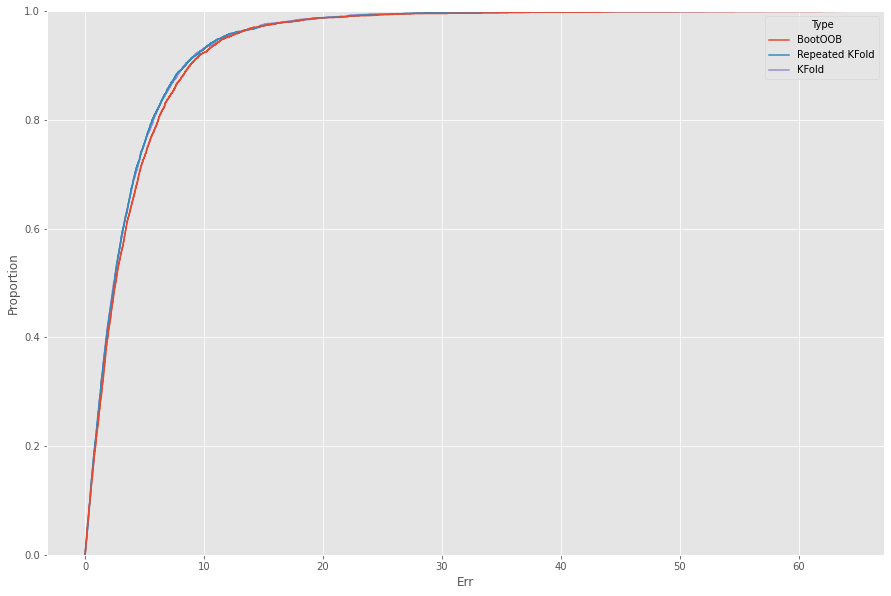

In [154]:
plt.figure(figsize = (15,10))
g = sns.ecdfplot(d_err, x = "Err", hue = 'Type')
#g.set(xlim = (0, 10))

In [155]:
stats = d_err.groupby('Type').describe().round(2)
stats

Err                                          
                 count  mean   std  min   25%   50%   75%    max
Type                                                            
BootOOB         3989.0  3.97  4.66  0.0  1.14  2.56  5.25  63.34
KFold           3989.0  3.75  4.36  0.0  1.06  2.40  4.88  63.99
Repeated KFold  3989.0  3.74  4.35  0.0  1.04  2.45  4.88  57.04

## RandomForestRegressor

In [142]:
from sklearn.ensemble import RandomForestRegressor

In [143]:
model = RandomForestRegressor(max_depth = 1000, random_state = 1)

In [144]:
#Bootstrap Out of Bag
scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err2 = abs(scores2['estimator'][scores2['test_score'].argmax()].predict(X_test) - y_test.to_numpy().reshape(1, -1))

In [145]:
#Repeated K-Fold
scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), scoring = 'neg_mean_absolute_error', return_estimator = True)
err3 = abs(scores3['estimator'][scores3['test_score'].argmax()].predict(X_test) - y_test.to_numpy().reshape(1, -1))

In [146]:
#K-Fold
scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, scoring = 'neg_mean_absolute_error',return_estimator = True)
err4 = abs(scores4['estimator'][scores4['test_score'].argmax()].predict(X_test) - y_test.to_numpy().reshape(1, -1))

In [150]:
d_err = []
d_err = pd.DataFrame({'Err':err2.reshape(-1), 'Type': 'BootOOB'})
d_err = d_err.append(pd.DataFrame({'Err':err3.reshape(-1), 'Type': 'Repeated KFold'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err4.reshape(-1), 'Type': 'KFold'}),ignore_index=True)

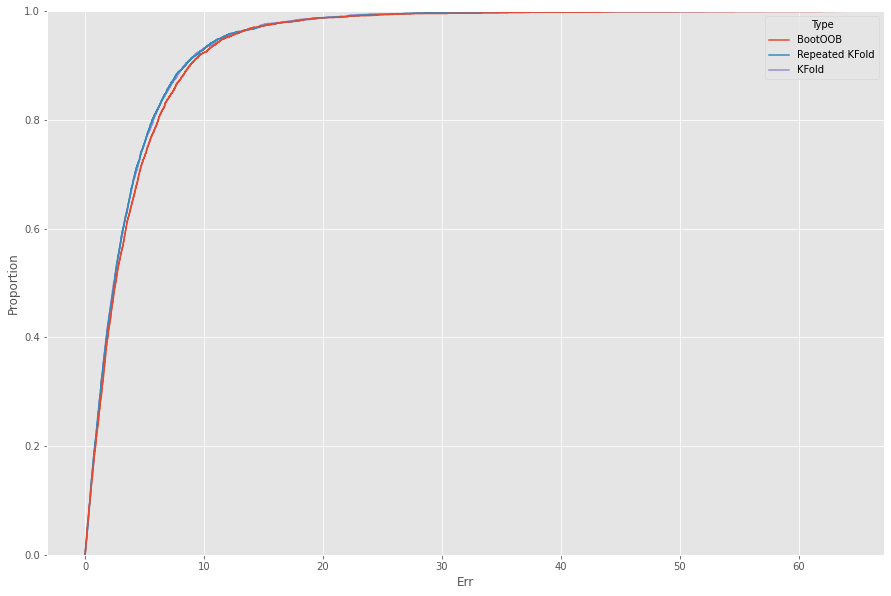

In [151]:
plt.figure(figsize = (15,10))
g = sns.ecdfplot(d_err, x = "Err", hue = 'Type')
#g.set(xlim = (0, 10))

In [152]:
stats = d_err.groupby('Type').describe().round(2)
stats

Err                                          
                 count  mean   std  min   25%   50%   75%    max
Type                                                            
BootOOB         3989.0  3.97  4.66  0.0  1.14  2.56  5.25  63.34
KFold           3989.0  3.75  4.36  0.0  1.06  2.40  4.88  63.99
Repeated KFold  3989.0  3.74  4.35  0.0  1.04  2.45  4.88  57.04